In [3]:
# %matplotlib qt5
%matplotlib inline
import numpy as np
from numpy import linalg as la
import matplotlib.pylab as plt
from scipy.optimize import fsolve
import math
import statsmodels.api as sm
from scipy.stats import norm
import seaborn as sns
from scipy import stats
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from utils import *

In [4]:
import scipy
from functools import partial
def odeIntegral(x,t,J,I=0):
    x = np.squeeze(x)
    x = np.reshape(x,(len(x),1))
    # dxdt = -x+J@np.tanh(x)#+I[0]
    dxdt = -x+J@(x)+I[0]
    return np.squeeze(dxdt)
def odesimulation(t,xinit,Jpt,I):
	return scipy.integrate.odeint(partial(odeIntegral,J=Jpt,I=I),xinit,t)

#### Network Construction

In [5]:
### define the network parameters of the adjacency matrix
nn = [50,100,150,250,750,800,1200]
g, gamma = 6.0, 1/4.0#1.5,1/1.#
NE = nn[-1] ## Network size = 1500
NI = int(gamma*NE)
N  = NE+NI
ALPHAE, ALPHAI = NE/N, NI/N
c = 0.2 ### sparsity, identical for excitatory and inhibitory neuron populations
KE, KI = int(c*NE), int(c*NI) ### fixed out-degree
J = 1/np.sqrt(1500)*0.5  ### TODO: make sure this scalar with David&Stefano's paper
print('number of connected E/I neurons:',KE,KI)
print('non-zero J:',J)
ji,je = g*J,J 

### define the network parameters of the diluted Gaussian matrix 
ge, gi = np.sqrt(je**2*c*(1-c)*N), np.sqrt(ji**2*c*(1-c)*N) 
hat_sigmae, hat_sigmai = np.sqrt(c*(1-c)), np.sqrt(c*(1-c))### standard deviation of the adjacency matrix
sigmae,sigmai = np.sqrt(c*(1-c)*J**2*N), np.sqrt(c*(1-c)*(-g*J)**2*N)### with magnitude of the coupling
JE,JI = je*c*NE, ji*c*NI 
lambda0 = JE-JI 
print('lambda0:',lambda0)
print('ge,gi:',ge,gi)
print('JE,JI:',JE,JI)

number of connected E/I neurons: 240 60
non-zero J: 0.012909944487358056
lambda0: -1.5491933384829668
ge,gi: 0.2 1.2000000000000002
JE,JI: 3.0983866769659336 4.6475800154489


In [6]:
ntau   = 10#21#
trials = 30+6#6
tau_series = np.linspace(0,0.225,ntau)# np.linspace(0.25,0.4,ntau)#
eigvchn_series, eigrvec_series, eiglvec_series = np.zeros((trials,ntau,N),dtype=complex), np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
eiglvec0_series, norml0_series = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau+1,N)) 
### normalization for left and right eigenvectors 
norms_for_lvec, norms_for_rvec = np.zeros((trials,ntau+1,2)), np.zeros((trials,ntau+1,2))
### also have the reconstructed left and right eigenvectors 
eigrvec_series_rec, eiglvec_series_rec = np.zeros((trials,ntau,N,2)), np.zeros((trials,ntau,N,2))
htau = tau_series[1]-tau_series[0]
### mean connectivity
nvec, mvec = np.zeros((N,1)), np.ones((N,1))
nvec[:NE,0], nvec[NE:,0] = N*JE/NE, -N*JI/NI
Jbar = mvec@nvec.T/N 
## TEST THE EIGENVALUES OF THE MEAN MATRIX 
eigvJ0, eigvecJ0 = la.eig(Jbar)
print('eigvJ0:',eigvJ0[0],' theory:',JE-JI)
### mean left and right eigenvectors
leigvec0, reigvec0 = np.zeros((N,N)), np.zeros((N,N))
norm_left = np.zeros(2)
## first eigenvector
leigvec0[:,0], reigvec0[:,0] = nvec[:,0]/(JE-JI)/np.sqrt(N), mvec[:,0]/np.sqrt(N)
norm_left[0]  = la.norm(leigvec0[:,0])
leigvec0[:,0] = leigvec0[:,0]/norm_left[0]
norml0_series[:,0,0] = np.sum(leigvec0[:,0]*reigvec0[:,0])
## second eigenvector
kk = np.sqrt(NE*JI**2+NI*JE**2)
reigvec0[:NE,1], reigvec0[NE:,1] = JI/kk,JE/kk 
leigvec0[:NE,1], leigvec0[NE:,1] = -kk/(JE-JI)/NE,kk/(JE-JI)/NI 
norm_left[1]  = la.norm(leigvec0[:,1])
leigvec0[:,1] = leigvec0[:,1]/norm_left[1]
norml0_series[:,0,1] = np.sum(leigvec0[:,1]*reigvec0[:,1])
outerproduct = np.sum(leigvec0[:,0]*reigvec0[:,1])#*norm_left
### compute the square of the random connectivity 
Z2E = N*J**2*hat_sigmae**2*tau_series*ALPHAE-N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAI
Z2I = -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAE+N*g**2*J**2*hat_sigmai**2*tau_series*ALPHAI
DeltaZ2E, DeltaZ2I = Z2E[1]-Z2E[0],Z2I[1]-Z2I[0] ### for practical use
print('DeltaZ2E,DeltaZ2I:',DeltaZ2E,DeltaZ2I)
DeltaZ2 = np.zeros((N,N))
DeltaZ2[:,:NE], DeltaZ2[:,NE:] = DeltaZ2E, DeltaZ2I

### E population and I population separately
Z2E_E, Z2I_E = N*J**2*hat_sigmae**2*tau_series*ALPHAE, -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAI
Z2E_I, Z2I_I = -N*g*J**2*hat_sigmae*hat_sigmai*tau_series*ALPHAE, N*g**2*J**2*hat_sigmai**2*tau_series*ALPHAI
DeltaZ2E_E, DeltaZ2I_E = Z2E_E[1]-Z2E_E[0],Z2I_E[1]-Z2I_E[0] ### for practical use
DeltaZ2E_I, DeltaZ2I_I = Z2E_I[1]-Z2E_I[0],Z2I_I[1]-Z2I_I[0] ### for practical use
DeltaZ2_E, DeltaZ2_I = np.zeros((N,N)),np.zeros((N,N))
DeltaZ2_E[:,:NE], DeltaZ2_E[:,NE:] = DeltaZ2E_E, DeltaZ2I_E

eigvJ0: (-1.5491933384830117+0j)  theory: -1.5491933384829668
DeltaZ2E,DeltaZ2I: -0.0004000000000000003 0.0024000000000000002


In [17]:
#### constant and deterministic input signal
Inp   = np.squeeze(np.ones((N,1)))/np.sqrt(N) 
tt = np.linspace(0,100,1000)
#### random and structural input signal 
### simulation using the mean network connectivity (inhibition-dominated)
Jpt   = Jbar.copy()
xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
xtemporal = odesimulation(tt, xinit, Jpt, Inp)
firing_rate0 = np.reshape(xtemporal[-1,:N],(N,1))

### generate i.i.d. s
def randbin(M,N,P):  
    return np.random.choice([0, 1], size=(M,N), p=[P, 1-P])

sparseiid_dyns = np.zeros((trials,N,1))
for ktrial in range(trials):
    ### generate iid sparse connectivity 
    Ecol = randbin(1,NE*N,1-ce)
    Icol = randbin(1,NI*N,1-ci)
    Ecol = np.reshape(Ecol,(N,NE))
    Icol = np.reshape(Icol,(N,NI))
    iidsparse = np.zeros((N,N))
    iidsparse[:,:NE], iidsparse[:,NE:] = Ecol.copy()*J,Icol.copy()*J*(-g)
    xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
    xtemporal = odesimulation(tt, xinit, iidsparse, Inp)
    firing_rate0 = np.reshape(xtemporal[-1,:N],(N,1))
    sparseiid_dyns[ktrial,:,:] = firing_rate0.copy()
    
sparseiid_dyns = np.squeeze(sparseiid_dyns)
mean_sparseiid_dyns = np.zeros((trials,2))
for ktrial in range(trials):
    mean_sparseiid_dyns[ktrial,0],mean_sparseiid_dyns[ktrial,1]= np.mean(sparseiid_dyns[ktrial,:NE]),np.mean(sparseiid_dyns[ktrial,NE:])
trialavg_sparseiid_dyns = np.mean(mean_sparseiid_dyns,axis=0)
trialstd_sparseiid_dyns = np.std(mean_sparseiid_dyns,axis=0)
print(trialavg_sparseiid_dyns)

[0.01014282 0.01014154]


#### Loading stored Sparse Network Data

In [66]:
# data_name = "/Users/shaoyuxiu/Library/CloudStorage/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/ConnStats_WD_Adjacency_4April_PRX_60N1500_normlr_whilecode_used_vecrec.npz"
data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/sonets/ConnStats_WD_Adjacency_4April_PRX_60N1500_normlr_whilecode_used_vecrec.npz"
# data_name = "/Users/shaoyuxiu/Library/CloudStorage/Dropbox/DailyWork/Allen_project/preparation4paper_Data/Numerics/Biological_sonet_transpose_lvec_PRX_60N1500_normlr_compare.npz"
# data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/Numerics/Biological_sonet_transpose_lvec_PRX_60N1500_normlr_compare.npz"
### load the stored data, in particular, extracting variable: eigvchn_series 
data = np.load(data_name,allow_pickle=True)

### also loading other variables 
eigvchn_series_sp  = data['eigvchn_series']
eigrvec_series_sp  = data['eigrvec_series']
eiglvec_series_sp  = data['eiglvec_series']
eiglvec0_series_sp = data['eiglvec0_series']#'eiglvec0norm_series']#eiglvec0_series']
params = data['params']
firing_rateeq_sp = data['firing_rateeq']

### numerical
mean_reigvec_num_series_sp  = np.zeros((trials,ntau,2,2))
mean_leigvec_num_series_sp  = np.zeros((trials,ntau,2,2))
mean_leig0vec_num_series_sp = np.zeros((trials,ntau,2,2))

thl = 1.5
ths = 1.5
threshold = thl
### for the numerical 
for ktrial in range(trials):
    for it in range(ntau):
        for ir in range(2):
            mean_reigvec_num_series_sp[ktrial,it,ir,0] = np.mean(eigrvec_series_sp[ktrial,it,:NE,ir])
            mean_reigvec_num_series_sp[ktrial,it,ir,1] = np.mean(eigrvec_series_sp[ktrial,it,NE:,ir])
            mean_leigvec_num_series_sp[ktrial,it,ir,0] = np.mean(eiglvec_series_sp[ktrial,it,:NE,ir])*eigvchn_series_sp[ktrial,it,ir].real
            # print('....',mean_leigvec_num_series_sp[ktrial,it,ir,0])
            mean_leigvec_num_series_sp[ktrial,it,ir,1] = np.mean(eiglvec_series_sp[ktrial,it,NE:,ir])*eigvchn_series_sp[ktrial,it,ir].real
            mean_leig0vec_num_series_sp[ktrial,it,ir,0] = np.mean(eiglvec0_series_sp[ktrial,it,:NE,ir])
            mean_leig0vec_num_series_sp[ktrial,it,ir,1] = np.mean(eiglvec0_series_sp[ktrial,it,NE:,ir])
            
### select the middle 30 values 
kktrial = np.arange(trials)
cuts = 6#3#
for it in range(ntau):
    for ir in range(2):        
        idxsort = np.argsort(mean_reigvec_num_series_sp[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:]) 
        mean_reigvec_num_series_sp[idxnan,it,ir,0] = np.nan 
        idxnan = np.where(np.abs(mean_reigvec_num_series_sp[:,it,ir,0].real)>threshold)[0]
        mean_reigvec_num_series_sp[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_reigvec_num_series_sp[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_reigvec_num_series_sp[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_reigvec_num_series_sp[:,it,ir,1].real)>threshold)[0]
        mean_reigvec_num_series_sp[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series_sp[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series_sp[idxnan,it,ir,0] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series_sp[:,it,ir,0].real)>threshold)[0]
        mean_leigvec_num_series_sp[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series_sp[:,it,ir,1].real)
        idxnan  = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series_sp[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_leigvec_num_series_sp[:,it,ir,1].real)>threshold)[0]
        mean_leigvec_num_series_sp[idxnan,it,ir,1] = np.nan

In [67]:
mean_leigvec_num_series_sp[:,1,1,1]

array([            nan, -4.10430004e-03, -1.12708153e-03,             nan,
       -3.87087253e-03,  6.99282579e-05,  9.79914823e-04,  4.52000073e-03,
       -3.26466130e-03, -1.44371453e-02,             nan,  8.98947167e-03,
                   nan,             nan, -4.57427214e-03, -2.09092725e-02,
        9.92399506e-03, -6.92386274e-03,             nan, -2.33802659e-03,
        1.43275975e-02, -2.07113453e-02,             nan, -7.18825015e-03,
                   nan, -2.99028427e-03, -1.58710134e-02,             nan,
        1.47374814e-02,  3.36504807e-03,  1.34823833e-02,             nan,
                   nan, -1.68888434e-02,             nan,  1.06346467e-02])

In [57]:
### compute the numerical radius
radius_num_map = np.zeros((trials,ntau))
for ktrial in range(trials):
    for it in range(ntau): 
        eigvchn_sp = eigvchn_series_sp[ktrial,it,:].copy()

        eigvchn_real_sp = np.real(eigvchn_sp)
        eigvchn_real_sp = np.sort(eigvchn_real_sp)
        eigvchn_real_sp = eigvchn_real_sp[::-1]

        radius = (eigvchn_real_sp[2])
        radius_num_map[ktrial,it] = radius

In [58]:
#### print trial by trial the first two eigenvallues
for ktrial in range(trials):
    eigvchn_sp = eigvchn_series_sp[ktrial,:,:].copy()
    eigvchn_real_sp = (eigvchn_sp)
### sorting the 3 maximum eigvchn_series[:,-1,0].real and 3 minimum
eigvchn_real_sp = eigvchn_series_sp[:,-1,0].real.copy()
### sorting eigvchn_real 
idx = np.argsort(eigvchn_real_sp)
idx_eff = idx[3:-3]
print('effective trials:',idx_eff,len(idx_eff))

effective trials: [ 8 20 21 29 24  9 15 17  4  0 30 35  3 31 14  5 13 25 28 18 10 33 34 12
 26 16  1 23  7 22] 30


In [11]:
ce, ci = c,c
radius_theo_map = np.zeros(ntau)
for it, tau in enumerate(tau_series):
    ### mean connectivity 
    je, ji = J, g*J
    hat_sigmae, hat_sigmai = np.sqrt(ce*(1-ce)),np.sqrt(ci*(1-ci))
    sigmae, sigmai = np.sqrt(je**2*ce*(1-ce)*N), np.sqrt(ji**2*ci*(1-ci)*N) 
    ### generate tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec
    tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec = np.zeros(2),np.zeros((2,2)),np.zeros((2,2)),np.zeros((2,2))
    ### YS: alltaus do not have E-I polarity
    tau_div_vec = np.array([tau,tau])
    tau_con_vec = np.array([[tau,tau],[tau,tau]])
    # tau_rec_vec = np.array([[0,0],[0,0]])
    tau_rec_vec = np.array([[2*tau,2*tau],[2*tau,2*tau]])
    tau_chn_vec = np.array([[tau,tau],[tau,tau]])
    # gamma = 1.0 ## NI/NE
    sigma = np.sqrt(sigmae**2/(1+gamma)+sigmai**2*gamma/(1+gamma))
    ### compute the radius 
    # compute a single number for multiple populations
    tau_div_num = hat_sigmae**2*tau_div_vec[0]+gamma*g**2*hat_sigmai**2*tau_div_vec[1]
    tau_div_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_div = tau_div_num/tau_div_den

    tau_con_num = hat_sigmae**2*tau_con_vec[0,0]+gamma*g**2*hat_sigmai**2*tau_con_vec[1,1]
    tau_con_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_con  = tau_con_num/tau_con_den

    tau_rec_num = hat_sigmae**2*tau_rec_vec[0,0] - (1+gamma)*g*hat_sigmae*hat_sigmai*tau_rec_vec[0,1]+gamma*g**2*hat_sigmai**2*tau_rec_vec[1,1]
    tau_rec_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_rec = tau_rec_num/tau_rec_den/2.0 

    tau_chn_num = hat_sigmae**2*tau_chn_vec[0,0] - 0.5*(1+gamma)*g*hat_sigmae*hat_sigmai*(tau_chn_vec[0,1]+tau_chn_vec[1,0])+gamma*g**2*hat_sigmai**2*tau_chn_vec[1,1]
    tau_chn_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_chn = tau_chn_num/tau_chn_den/2.0

    radius_theo = (1.0-tau_con-tau_div+tau_rec-2*tau_chn)/np.sqrt(1-tau_con-tau_div)*sigma
    
    radius_theo_map[it] = radius_theo
            
### theoretical prediction of the eigenvalues

org_k = J*N*(ALPHAE-g*ALPHAI)/2.0
eigvchn_theo = np.zeros((ntau,2))
eigvchn_theo[:,0] = org_k*(c+np.sqrt(c**2+4*c*(1-c)*tau_series))
eigvchn_theo[:,1] = org_k*(c-np.sqrt(c**2+4*c*(1-c)*tau_series))

In [18]:
eigvchn_theo,radius_theo_map

(array([[-1.54919334, -0.        ],
        [-1.69111181,  0.14191847],
        [-1.81382715,  0.26463382],
        [-1.9235092 ,  0.37431586],
        [-2.02359627,  0.47440293],
        [-2.11623746,  0.56704412],
        [-2.20288235,  0.65368902],
        [-2.28456356,  0.73537022],
        [-2.36204746,  0.81285412],
        [-2.43592144,  0.8867281 ]]),
 array([0.56568542, 0.55136195, 0.53665631, 0.52153619, 0.50596443,
        0.48989795, 0.47328638, 0.45607017, 0.43817805, 0.41952354]))

Fig 9 inset

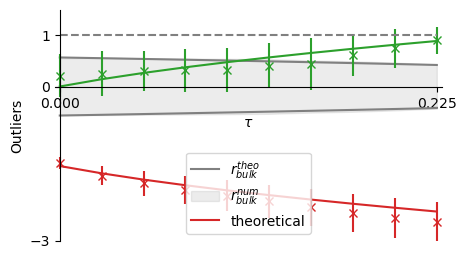

In [19]:
### plot the numerical and theoretical eigenvalues outliers
fig,ax = plt.subplots(figsize=(5,3))
### label is r_{bulk}^{num}
ax.plot(tau_series,radius_theo_map,'gray',label=r'$r_{bulk}^{theo}$')
ax.plot(tau_series,-radius_theo_map,'gray')
ax.fill_between(tau_series,np.mean(radius_num_map,axis=0),-np.mean(radius_num_map,axis=0),color='gray',alpha=0.15,label=r'$r_{bulk}^{num}$')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Radius')
ax.legend()

alphass= 1

ax.plot(tau_series,eigvchn_theo[:,0],'tab:red',label='theoretical',alpha=alphass)
ax.plot(tau_series,eigvchn_theo[:,1],'tab:green',alpha=alphass)

### plot error bar  
ax.errorbar(tau_series,np.mean(eigvchn_series_sp[idx_eff,:,0].real,axis=0),yerr=np.std(eigvchn_series_sp[idx_eff,:,0].real,axis=0),fmt='x',color='tab:red',ecolor='tab:red',alpha=alphass,ls='',elinewidth=1.5)

ax.errorbar(tau_series,np.mean(eigvchn_series_sp[idx_eff,:,1].real,axis=0),yerr=np.std(eigvchn_series_sp[idx_eff,:,1].real,axis=0),fmt='x',color='tab:green',ecolor='tab:green',alpha=alphass,ls='',elinewidth=1.5)
    
ax.set_xlabel(r'$\tau$')
ax.set_ylabel('Outliers')
### set x and y lims as well as ticks
dtau = tau_series[1]-tau_series[0] 
ax.set_xlim([tau_series[0]-dtau/8,tau_series[-1]+dtau/8])
ax.set_xticks([tau_series[0],tau_series[-1]])
ax.set_ylim([-3,1.5])
ax.set_yticks([-3,0,1])
ax.plot([0,tau_series[-1]],[1,1],color='gray',linestyle='--',linewidth=1.5)
ax.legend()
### move the x and y axis to the center
ax.spines['bottom'].set_position(('data',0))
ax.spines['left'].set_position(('data',tau_series[0]))
### set other x-axis invisible
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.show()

#### Simulations -- Gaussian Approximation Network

In [20]:
### only the first pair of connectivity vectors
### if you want to re-run the simulation
# trials = 6
eiglvec0norm_series = np.zeros((trials,ntau,N,2))
leig0mean_series    = np.zeros((trials,ntau,N,2))
leig0pre_series     = np.zeros((trials,ntau,N,2))
### simulation using the low-rank framework
firing_rateeq = np.zeros((trials,ntau,N))
firing_rateeq_bulk = np.zeros((trials,ntau,N))
z_pre = np.zeros((N,N))
switch,factor = 4,1

### trials random networks and vectors 
xrs   = np.zeros((trials,N,N))
xrecs = np.zeros((trials,N,N))
chnetas = np.zeros((trials,N,6))

flag_run = True
### generate the random connectivity components
for ktrial in range(trials):
    while (flag_run):
        xr      = iidGaussian([0,1/np.sqrt(N)],[N,N]) ## iid random component
        chneta  = iidGaussian([0,1/np.sqrt(N)],[N,6]) ## chain correlation
        xrec    = iidGaussian([0,1/np.sqrt(N)],[N,N]) ## reciprocal 
        ### zscore
        xr   = stats.zscore(xr.flatten())
        xr   = xr*1/np.sqrt(N)
        xr   = np.reshape(xr,(N,N))
        ### zscore
        xrec = stats.zscore(xrec.flatten())
        xrec = xrec*1/np.sqrt(N)
        xrec = np.reshape(xrec,(N,N))
        # ### zscore
        # nsample = 20
        chneta  = iidGaussian([0,1/np.sqrt(N)],[N,6])
        chneta[:,0] = stats.zscore(chneta[:,0])
        chneta[:,0] *=(1/np.sqrt(N))
        
        tau = tau_series[-1]
        a    = np.sqrt(tau)
        zrow = a*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
        zcol = a*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
        gammarec = a*xrec-a*xrec.copy().T
        ### adjacency matrix
        zr   = zrow.copy()+zcol.copy()+np.sqrt(1-2*tau)*xr### without considering the reciprocal term
        ### E-I matrix 
        zr[:,:NE],zr[:,NE:] = zr[:,:NE]*ge,zr[:,NE:]*(-gi)        
        ### generate J connectivity matrix
        Jchn = Jbar.copy()+zr.copy()           
        eigvchn, eigrvec = la.eig(Jchn)
        FIRSTV = np.abs(eigvchn[0]-eigvchn_theo[-1,0])/np.abs(eigvchn_theo[-1,0])
        SECONDV = np.abs(eigvchn[1]-eigvchn_theo[-1,1])/np.abs(eigvchn_theo[-1,1])
        if FIRSTV<0.1 and SECONDV<0.1 and eigvchn[0].imag==0 and eigvchn[1].imag==0:
            flag_run = False
            print('eigvchn:',eigvchn[:2],'theory:',eigvchn_theo[-1,:])
    ### ---------------------
    print('Go run...........................')
    
    xrs[ktrial,:,:]      = xr.copy()
    chnetas[ktrial,:,:]  = chneta.copy()
    xrecs[ktrial,:,:]    = xrec.copy()
    flag_run = True

### if you want to re-run the simulations for dynamics, set rerun_dyns to be True 
htau = tau_series[-1]-tau_series[-2]
for it, tau in enumerate(tau_series):
    a    = np.sqrt(tau)
    norm_lvec = np.zeros(2)
    for ktrial in range(trials):
        xr      = xrs[ktrial,:,:]
        chneta  = chnetas[ktrial,:,:]
        xrec    = xrecs[ktrial,:,:]
        
        zrow = a*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
        zcol = a*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
        gammarec = a*xrec-a*xrec.copy().T
        # zr   = zrow.copy()+zcol.copy()+np.sqrt(1-4*tau)*xr+gammarec
        zr   = zrow.copy()+zcol.copy()+np.sqrt(1-2*tau)*xr
        zr[:,:NE],zr[:,NE:] = zr[:,:NE]*ge,zr[:,NE:]*(-gi)
        if it==0:
            zr_pre = np.zeros_like(zr)
        else:
            a_pre = np.sqrt(tau_series[it-1])
            zrow_pre = a_pre*np.repeat(np.reshape(chneta[:,0],(1,-1)),N,axis=0)
            zcol_pre = a_pre*np.repeat(np.reshape(chneta[:,0],(-1,1)),N,axis=1)
            gammarec_pre = a_pre*xrec-a_pre*xrec.copy().T
            zr_pre   = zrow_pre.copy()+zcol_pre.copy()+np.sqrt(1-2*tau_series[it-1])*xr
            zr_pre[:,:NE],zr_pre[:,NE:] = zr_pre[:,:NE]*ge,zr_pre[:,NE:]*(-gi)

        ### generate J connectivity matrix
        Jchn = Jbar.copy()+zr.copy()
        ### full rank simulation
        xinit = np.squeeze(np.random.normal(0, 1E-2, (1, N)))
        xc_temporal = odesimulation(tt, xinit, Jchn, Inp)
        firing_rateeq[ktrial,it,:] = xc_temporal[-1,:].copy()
        
        eigvchn, eigrvec = la.eig(Jchn)
        eigvchn_,eiglvec = la.eig(Jchn.copy().T)
        assert(np.sum(np.abs(eigvchn[0]-eigvchn_[0]))<1e-9)## check the consistency of left and right eigenvectors
        ### normalization
        reig  = np.squeeze(eigrvec[:,:].copy())            
        ### inverse left eigenvector
        inveigrvec       = la.inv(eigrvec)
        leig = np.squeeze(inveigrvec[:,:].copy()) # inverse
        leig = leig.copy().T
        ### leig0 is normalized 
        norm_lvec += la.norm(leig[:,:2],axis=0)
        leig0 = leig/la.norm(leig,axis=0)

        if np.mean(reig[:NE,0])<0:
            reig[:,0]*=-1
            leig[:,0]*=-1
            leig0[:,0]*=-1
        if np.mean(reig[:NE,1])<0: ### the second rank-1 component is negative
            reig[:,1]*=-1
            leig[:,1]*=-1
            leig0[:,1]*=-1
        
        eigvchn_series[ktrial,it,:]    = eigvchn.copy()#eigvw_norm.copy()#
        eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
        eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
        eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#

C:\Users\Administrator\AppData\Local\Temp\ipykernel_27856\1399497968.py:120: ComplexWarning: Casting complex values to real discards the imaginary part
  eigrvec_series[ktrial,it,:,:]  = reig[:,:2].copy()#eigvecw_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27856\1399497968.py:121: ComplexWarning: Casting complex values to real discards the imaginary part
  eiglvec_series[ktrial,it,:,:]  = leig[:,:2].copy()#eigvect_norm.copy()#
C:\Users\Administrator\AppData\Local\Temp\ipykernel_27856\1399497968.py:122: ComplexWarning: Casting complex values to real discards the imaginary part
  eiglvec0_series[ktrial,it,:,:] = leig0[:,:2].copy()#eigvect_norm.copy()#


Save the data 

In [12]:

params = {'g':g,
          'gamma':gamma,
          'NE':NE,
          'NI':NI,
          'J':J,
          'ce':ce,
          'ci':ci,
          'tau_series':tau_series,
          }
lst = [eigvchn_series, eigrvec_series, eiglvec_series,
       eigrvec_series_rec, eiglvec_series_rec,
        eiglvec0_series, norml0_series, params,
        leig0mean_series,
        firing_rateeq]
stg = ["eigvchn_series, eigrvec_series, eiglvec_series,"
       "eigrvec_series_rec, eiglvec_series_rec,"
        "eiglvec0_series, norml0_series, params,"
        "leig0mean_series,"
        "firing_rateeq"]
# data = list_to_dict(lst=lst, string=stg)
switch = 4
# data_name = "/Users/shaoyuxiu/Library/CloudStorage/Dropbox/DailyWork/Allen_project/preparation4paper_Data/Numerics_remote/Biological_PRX_60N1500_normlr_theory_compare_update_inttheo_"+str(switch)+"_.npz"
data_name = "E:/Dropbox/DailyWork/Allen_project/preparation4paper_Data/Numerics/Biological_PRX_60N1500_normlr_theory_compare_update_inttheo_"+str(switch)+"_.npz"
# data_name = "/Users/shaoyuxiu/Library/CloudStorage/Dropbox/DailyWork/Allen_project/preparation4paper_Data/Numerics/Biological_PRX_60N1500_normlr_theory_compare.npz"
# # data_name = "your data folder/XXX.npz"
# np.savez(data_name, **data)
data = np.load(data_name,allow_pickle=True)
### also loading other variables 
eigvchn_series  = data['eigvchn_series']
eigrvec_series  = data['eigrvec_series']
eiglvec_series  = data['eiglvec_series']
eiglvec0_series = data['eiglvec0_series']
params   = data['params']
firing_rateeq = data['firing_rateeq']
intg_ml0 = data['intg_ml0']
intg_mr  = data['intg_mr']
intg_ml  = data['intg_ml']


In [21]:
### compute the trial averaged mean 
# eigvchn_series = data['eigvchn_series']
# ntau = np.shape(eigvchn_series)[1]
# trials = np.shape(eigvchn_series)[0]
# NE, NI = params['NE'],params['NI']
### numerical  
mean_reigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leigvec_num_series = np.zeros((trials,ntau,2,2))
mean_leig0vec_num_series = np.zeros((trials,ntau,2,2))
thl = 1.5
ths = 1.5
threshold = thl       
### for the numerical 
for ktrial in range(trials):
    for it in range(ntau):
        for ir in range(2):
            mean_reigvec_num_series[ktrial,it,ir,0] = np.mean(eigrvec_series[ktrial,it,:NE,ir])
            mean_reigvec_num_series[ktrial,it,ir,1] = np.mean(eigrvec_series[ktrial,it,NE:,ir])
            mean_leigvec_num_series[ktrial,it,ir,0] = np.mean(eiglvec_series[ktrial,it,:NE,ir])*eigvchn_series[ktrial,it,ir].real
            mean_leigvec_num_series[ktrial,it,ir,1] = np.mean(eiglvec_series[ktrial,it,NE:,ir])*eigvchn_series[ktrial,it,ir].real
            mean_leig0vec_num_series[ktrial,it,ir,0] = np.mean(eiglvec0_series[ktrial,it,:NE,ir])
            mean_leig0vec_num_series[ktrial,it,ir,1] = np.mean(eiglvec0_series[ktrial,it,NE:,ir])
            
### select the middle 30 values 
kktrial = np.arange(trials)
cuts = 3#6#
for it in range(ntau):
    for ir in range(2):        
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:]) 
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan 
        idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,0].real)>threshold)[0]
        mean_reigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_reigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        idxnan = np.where(np.abs(mean_reigvec_num_series[:,it,ir,1].real)>threshold)[0]
        mean_reigvec_num_series[idxnan,it,ir,1] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,0].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,0] = np.nan
        
        idxsort = np.argsort(mean_leigvec_num_series[:,it,ir,1].real)
        idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
        mean_leigvec_num_series[idxnan,it,ir,1] = np.nan



In [68]:
# ## multiply the numerical simulation by np.sqrt(N)--rescaling
# mean_reigvec_num_series  *= np.sqrt(N)
# mean_leigvec_num_series  *= np.sqrt(N)
# mean_leig0vec_num_series *= np.sqrt(N)

mean_reigvec_num_series_sp  *= np.sqrt(N)
mean_leigvec_num_series_sp  *= np.sqrt(N)
mean_leig0vec_num_series_sp *= np.sqrt(N)

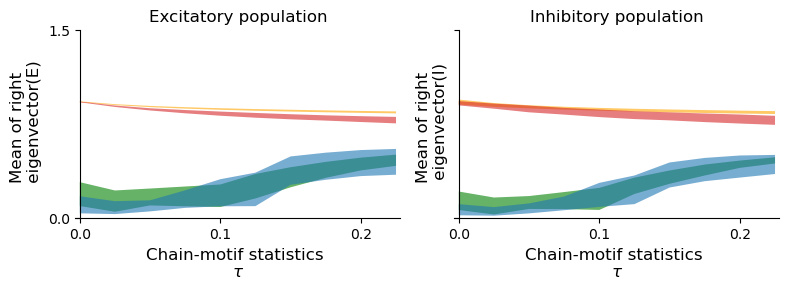

In [69]:
### plot the mean of the left and right eigenvectors
dtau = tau_series[1]-tau_series[0]
tau_max = tau_series[-1]
fig,ax=plt.subplots(1,2,figsize=(8,3),sharex=True,sharey=True)
ax[0].fill_between(tau_series,np.nanmean(mean_reigvec_num_series[:,:,0,0],axis=0)-np.nanstd(mean_reigvec_num_series[:,:,0,0],axis=0),np.nanmean(mean_reigvec_num_series[:,:,0,0],axis=0)+np.nanstd(mean_reigvec_num_series[:,:,0,0],axis=0),facecolor='orange',alpha=0.6)

ax[0].fill_between(tau_series,np.nanmean(mean_reigvec_num_series_sp[:,:,0,0],axis=0)-np.nanstd(mean_reigvec_num_series_sp[:,:,0,0],axis=0),np.nanmean(mean_reigvec_num_series_sp[:,:,0,0],axis=0)+np.nanstd(mean_reigvec_num_series_sp[:,:,0,0],axis=0),facecolor='tab:red',alpha=0.6)
# for i in range(trials):
#     ax[0].scatter(tau_series,mean_reigvec_num_series[i,:,0,0])
#     print(mean_reigvec_num_series[i,:,0,0])
## second rank
ax[0].fill_between(tau_series,np.nanmean(mean_reigvec_num_series[:,:,1,0],axis=0)-np.nanstd(mean_reigvec_num_series[:,:,1,0],axis=0),np.nanmean(mean_reigvec_num_series[:,:,1,0],axis=0)+np.nanstd(mean_reigvec_num_series[:,:,1,0],axis=0),facecolor='green',alpha=0.6)
ax[0].fill_between(tau_series,np.nanmean(mean_reigvec_num_series_sp[:,:,1,0],axis=0)-np.nanstd(mean_reigvec_num_series_sp[:,:,1,0],axis=0),np.nanmean(mean_reigvec_num_series_sp[:,:,1,0],axis=0)+np.nanstd(mean_reigvec_num_series_sp[:,:,1,0],axis=0),facecolor='tab:blue',alpha=0.6)

### excitatory population
ax[0].set_title('Excitatory population',fontsize=12)
## move the x-axis to  the cecnter
ax[0].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[0].spines['top'].set_color('none')
ax[0].spines['right'].set_color('none')
ax[0].spines['left'].set_position(('data',0))
ax[0].set_xticks([0,0.1,0.2])
ax[0].set_xlim(0,tau_max+0.02/8)
ax[0].set_ylim(-0.01,0.04)
ax[0].set_yticks([0,0.04])
ax[0].set_ylim(-0.,1.5)
ax[0].set_yticks([0,1.5])
ax[0].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[0].set_ylabel('Mean of right \n eigenvector(E)',fontsize=12)

### start the inhibitory population
ax[1].fill_between(tau_series,np.nanmean(mean_reigvec_num_series[:,:,0,1],axis=0)-np.nanstd(mean_reigvec_num_series[:,:,0,1],axis=0),np.nanmean(mean_reigvec_num_series[:,:,0,1],axis=0)+np.nanstd(mean_reigvec_num_series[:,:,0,1],axis=0),facecolor='orange',alpha=0.6)

ax[1].fill_between(tau_series,np.nanmean(mean_reigvec_num_series_sp[:,:,0,1],axis=0)-np.nanstd(mean_reigvec_num_series_sp[:,:,0,1],axis=0),np.nanmean(mean_reigvec_num_series_sp[:,:,0,1],axis=0)+np.nanstd(mean_reigvec_num_series_sp[:,:,0,1],axis=0),facecolor='tab:red',alpha=0.6)

## second rank
ax[1].fill_between(tau_series,np.nanmean(mean_reigvec_num_series[:,:,1,1],axis=0)-np.nanstd(mean_reigvec_num_series[:,:,1,1],axis=0),np.nanmean(mean_reigvec_num_series[:,:,1,1],axis=0)+np.nanstd(mean_reigvec_num_series[:,:,1,1],axis=0),facecolor='green',alpha=0.6)

ax[1].fill_between(tau_series,np.nanmean(mean_reigvec_num_series_sp[:,:,1,1],axis=0)-np.nanstd(mean_reigvec_num_series_sp[:,:,1,1],axis=0),np.nanmean(mean_reigvec_num_series_sp[:,:,1,1],axis=0)+np.nanstd(mean_reigvec_num_series_sp[:,:,1,1],axis=0),facecolor='tab:blue',alpha=0.6)

### move the x-axis to  the cecnter
ax[1].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[1].spines['top'].set_color('none')
ax[1].spines['right'].set_color('none')
ax[1].spines['left'].set_position(('data',0))
ax[1].set_title('Inhibitory population',fontsize=12)
ax[1].set_xticks([0,0.1,0.2])
ax[1].set_xlim(0-dtau/8.0,tau_max+dtau/8)
# ax[1].set_ylim(-0.01,0.04)
ax[1].set_ylim(-0.0,1.5)
ax[1].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[1].set_ylabel('Mean of right \n eigenvector(I)',fontsize=12)
fig.tight_layout()
plt.show()

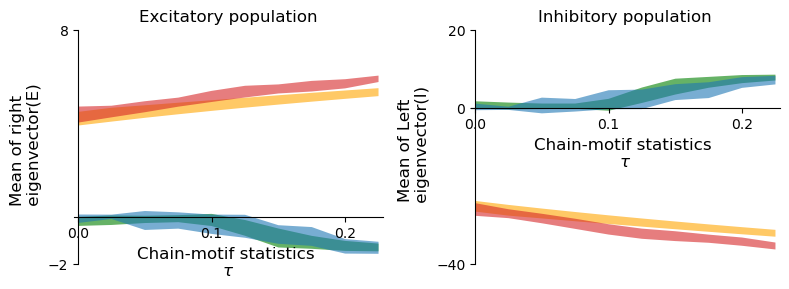

In [70]:
### plot the mean of the left and right eigenvectors
dtau = tau_series[1]-tau_series[0]
tau_max = tau_series[-1]
fig,ax=plt.subplots(1,2,figsize=(8,3),sharex=True)
ax[0].fill_between(tau_series,np.nanmean(mean_leigvec_num_series[:,:,0,0],axis=0)-np.nanstd(mean_leigvec_num_series[:,:,0,0],axis=0),np.nanmean(mean_leigvec_num_series[:,:,0,0],axis=0)+np.nanstd(mean_leigvec_num_series[:,:,0,0],axis=0),facecolor='orange',alpha=0.6)

# ax[0].fill_between(tau_series,np.nanmean(mean_leigvec_num_series_sp[:,:,0,0]*eigvchn_series_sp[:,:,0],axis=0)-np.nanstd(mean_leigvec_num_series_sp[:,:,0,0]*eigvchn_series_sp[:,:,0],axis=0),np.nanmean(mean_leigvec_num_series_sp[:,:,0,0]*eigvchn_series_sp[:,:,0],axis=0)+np.nanstd(mean_leigvec_num_series_sp[:,:,0,0]*eigvchn_series_sp[:,:,0],axis=0),facecolor='tab:red',alpha=0.6)

ax[0].fill_between(tau_series,np.nanmean(mean_leigvec_num_series_sp[:,:,0,0],axis=0)-np.nanstd(mean_leigvec_num_series_sp[:,:,0,0],axis=0),np.nanmean(mean_leigvec_num_series_sp[:,:,0,0],axis=0)+np.nanstd(mean_leigvec_num_series_sp[:,:,0,0],axis=0),facecolor='tab:red',alpha=0.6)

## second rank
ax[0].fill_between(tau_series,np.nanmean(mean_leigvec_num_series[:,:,1,0],axis=0)-np.nanstd(mean_leigvec_num_series[:,:,1,0],axis=0),np.nanmean(mean_leigvec_num_series[:,:,1,0],axis=0)+np.nanstd(mean_leigvec_num_series[:,:,1,0],axis=0),facecolor='green',alpha=0.6)

# ax[0].fill_between(tau_series,np.nanmean(mean_leigvec_num_series_sp[:,:,1,0]*eigvchn_series_sp[:,:,1],axis=0)-np.nanstd(mean_leigvec_num_series_sp[:,:,1,0]*eigvchn_series_sp[:,:,1],axis=0),np.nanmean(mean_leigvec_num_series_sp[:,:,1,0]*eigvchn_series_sp[:,:,1],axis=0)+np.nanstd(mean_leigvec_num_series_sp[:,:,1,0]*eigvchn_series_sp[:,:,1],axis=0),facecolor='tab:blue',alpha=0.6)
ax[0].fill_between(tau_series,np.nanmean(mean_leigvec_num_series_sp[:,:,1,0],axis=0)-np.nanstd(mean_leigvec_num_series_sp[:,:,1,0],axis=0),np.nanmean(mean_leigvec_num_series_sp[:,:,1,0],axis=0)+np.nanstd(mean_leigvec_num_series_sp[:,:,1,0],axis=0),facecolor='tab:blue',alpha=0.6)

### excitatory population
ax[0].set_title('Excitatory population',fontsize=12)
## move the x-axis to  the cecnter
ax[0].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[0].spines['top'].set_color('none')
ax[0].spines['right'].set_color('none')
ax[0].spines['left'].set_position(('data',0))
ax[0].set_xticks([0,0.1,0.2])
ax[0].set_xlim(0,tau_max+0.02/8)
# ax[0].set_ylim(-0.01,0.04)
# ax[0].set_yticks([0,0.04])
ax[0].set_ylim(-2.0,8)
ax[0].set_yticks([-2.0,8])
ax[0].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[0].set_ylabel('Mean of right \n eigenvector(E)',fontsize=12)

### start the inhibitory population
ax[1].fill_between(tau_series,np.nanmean(mean_leigvec_num_series[:,:,0,1],axis=0)-np.nanstd(mean_leigvec_num_series[:,:,0,1],axis=0),np.nanmean(mean_leigvec_num_series[:,:,0,1],axis=0)+np.nanstd(mean_leigvec_num_series[:,:,0,1],axis=0),facecolor='orange',alpha=0.6)

## second rank
ax[1].fill_between(tau_series,np.nanmean(mean_leigvec_num_series[:,:,1,1],axis=0)-np.nanstd(mean_leigvec_num_series[:,:,1,1],axis=0),np.nanmean(mean_leigvec_num_series[:,:,1,1],axis=0)+np.nanstd(mean_leigvec_num_series[:,:,1,1],axis=0),facecolor='green',alpha=0.6)

ax[1].fill_between(tau_series,np.nanmean(mean_leigvec_num_series_sp[:,:,0,1],axis=0)-np.nanstd(mean_leigvec_num_series_sp[:,:,0,1],axis=0),np.nanmean(mean_leigvec_num_series_sp[:,:,0,1],axis=0)+np.nanstd(mean_leigvec_num_series_sp[:,:,0,1],axis=0),facecolor='tab:red',alpha=0.6)

ax[1].fill_between(tau_series,np.nanmean(mean_leigvec_num_series_sp[:,:,1,1],axis=0)-np.nanstd(mean_leigvec_num_series_sp[:,:,1,1],axis=0),np.nanmean(mean_leigvec_num_series_sp[:,:,1,1],axis=0)+np.nanstd(mean_leigvec_num_series_sp[:,:,1,1],axis=0),facecolor='tab:blue',alpha=0.6)
### move the x-axis to  the cecnter
ax[1].spines['bottom'].set_position(('data',0))
### set other x-axis invisible
ax[1].spines['top'].set_color('none')
ax[1].spines['right'].set_color('none')
ax[1].spines['left'].set_position(('data',0))
ax[1].set_title('Inhibitory population',fontsize=12)
ax[1].set_xticks([0,0.1,0.2])
ax[1].set_xlim(0-dtau/8.0,tau_max+dtau/8)
ax[1].set_ylim(-40,20)
ax[1].set_yticks([-40,0,20])
ax[1].set_xlabel('Chain-motif statistics \n'+r'$\tau$',fontsize=12)
ax[1].set_ylabel('Mean of Left \n eigenvector(I)',fontsize=12)
fig.tight_layout()
plt.show()

Dynamics, compute the mean 

In [61]:
# ### multiply the numerical simulation by np.sqrt(N) -rescaling (back)
# mean_reigvec_num_series /= np.sqrt(N)
# mean_leigvec_num_series /= np.sqrt(N)

mean_reigvec_num_series_sp /= np.sqrt(N)
mean_leigvec_num_series_sp /= np.sqrt(N)


In [40]:
### compute low-rank theoretical (Gaussian Approximation)
contribution_fr = np.zeros((trials,ntau,2,2))
firing_rate_lwfr = np.zeros((trials,ntau,2))
for ktrial in range(trials):
    for it in range(ntau):
            for ir in range(2):
                contribution_fr[ktrial,it,ir,0] = np.squeeze(((mean_leigvec_num_series[ktrial,it,ir,0])*Inp[0]*NE+(mean_leigvec_num_series[ktrial,it,ir,1])*Inp[0]*NI)/(1-eigvchn_theo[it,ir].real)*(mean_reigvec_num_series[ktrial,it,ir,0]))
                contribution_fr[ktrial,it,ir,1] = np.squeeze(((mean_leigvec_num_series[ktrial,it,ir,0])*Inp[0]*NE+(mean_leigvec_num_series[ktrial,it,ir,1])*Inp[0]*NI)/(1-eigvchn_theo[it,ir].real)*(mean_reigvec_num_series[ktrial,it,ir,1]))
    firing_rate_lwfr[ktrial,:,:] = np.ones((ntau,2))*Inp[0]
    firing_rate_lwfr[ktrial,:,:] +=np.sum(contribution_fr[ktrial,:,:,:].copy(),axis=1)


In [41]:
# ## compute low-rank theoretical (SPARSE NETWORKS)
contribution_fr_sp = np.zeros((trials,ntau,2,2))
firing_rate_lwfr_sp = np.zeros((trials,ntau,2))
for ktrial in range(trials):
    for it in range(ntau):
            for ir in range(2):
                contribution_fr_sp[ktrial,it,ir,0] = np.squeeze(((mean_leigvec_num_series_sp[ktrial,it,ir,0])*Inp[0]*NE+(mean_leigvec_num_series_sp[ktrial,it,ir,1])*Inp[0]*NI)/(1-eigvchn_theo[it,ir].real)*(mean_reigvec_num_series_sp[ktrial,it,ir,0]))
                contribution_fr_sp[ktrial,it,ir,1] = np.squeeze(((mean_leigvec_num_series_sp[ktrial,it,ir,0])*Inp[0]*NE+(mean_leigvec_num_series_sp[ktrial,it,ir,1])*Inp[0]*NI)/(1-eigvchn_theo[it,ir].real)*(mean_reigvec_num_series_sp[ktrial,it,ir,1]))
    firing_rate_lwfr_sp[ktrial,:,:] = np.ones((ntau,2))*Inp[0]
    firing_rate_lwfr_sp[ktrial,:,:] +=np.sum(contribution_fr_sp[ktrial,:,:,:].copy(),axis=1)

In [42]:
### compute the population mean and variance
# ntau = 6
firing_rateeq_mean_sp,firing_rateeq_var_sp = np.zeros((trials,ntau,2)),np.zeros((trials,ntau,2))
firing_rateeq_mean_sp[:,:,0],firing_rateeq_mean_sp[:,:,1] = np.mean(firing_rateeq_sp[:,:,:NE],axis=2),np.mean(firing_rateeq_sp[:,:,NE:],axis=2)

firing_rateeq_mean,firing_rateeq_var = np.zeros((trials,ntau,2)),np.zeros((trials,ntau,2))
firing_rateeq_mean[:,:,0],firing_rateeq_mean[:,:,1] = np.mean(firing_rateeq[:,:,:NE],axis=2),np.mean(firing_rateeq[:,:,NE:],axis=2)


cuts = 6
for it in range(ntau):    
    idxsort = np.argsort(firing_rateeq_mean_sp[:,it,0])
    idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
    firing_rateeq_mean_sp[idxnan,it,0] = np.nan 
    
    idxsort = np.argsort(firing_rateeq_mean_sp[:,it,1])
    idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
    firing_rateeq_mean_sp[idxnan,it,1] = np.nan 
    
    idxsort = np.argsort(firing_rateeq_mean[:,it,0])
    idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
    firing_rateeq_mean[idxnan,it,0] = np.nan 
    
    idxsort = np.argsort(firing_rateeq_mean[:,it,1])
    idxnan = np.append(idxsort[:cuts],idxsort[-cuts:])
    firing_rateeq_mean[idxnan,it,1] = np.nan 


### ensuring there is no extreme value
firing_rate_lwfr_sp[np.where(firing_rate_lwfr_sp<0)]=np.nan
firing_rate_lwfr[np.where(firing_rate_lwfr<0)]=np.nan

firing_rate_lwfr_sp[np.where(firing_rate_lwfr_sp>0.6)]=np.nan
firing_rate_lwfr[np.where(firing_rate_lwfr>0.6)]=np.nan

firing_rateeq_mean_sp[np.where(firing_rateeq_mean_sp<0)]=np.nan
firing_rateeq_mean[np.where(firing_rateeq_mean<0)]=np.nan

firing_rateeq_mean_sp[np.where(firing_rateeq_mean_sp>0.1)]=np.nan
firing_rateeq_mean[np.where(firing_rateeq_mean>0.1)]=np.nan

contribution_fr_sp[np.where(contribution_fr_sp<-0.1)]=np.nan
contribution_fr[np.where(contribution_fr<-0.1)]=np.nan

contribution_fr_sp[np.where(contribution_fr_sp>0.6)]=np.nan
contribution_fr[np.where(contribution_fr>0.6)]=np.nan
    
    
    

Figure Finale

In [48]:
''' Theoretical prediction of the intersection between radius and eigenvalue outliers （When does the second eigenvalue outlier emerge from the bulk)'''

ce, ci = c,c

def cal_radius_eigv_intersection(x, J,g,gamma,ce,ci,N,ALPHAE,ALPHAI):
    tau = x[0]
    ### mean connectivity 
    je, ji = J, g*J
    hat_sigmae, hat_sigmai = np.sqrt(ce*(1-ce)),np.sqrt(ci*(1-ci))
    sigmae, sigmai = np.sqrt(je**2*ce*(1-ce)*N), np.sqrt(ji**2*ci*(1-ci)*N) 
    ### generate tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec
    tau_div_vec, tau_con_vec, tau_rec_vec, tau_chn_vec = np.zeros(2),np.zeros((2,2)),np.zeros((2,2)),np.zeros((2,2))
    ### YS: alltaus do not have E-I polarity
    tau_div_vec = np.array([tau,tau])
    tau_con_vec = np.array([[tau,tau],[tau,tau]])
    # tau_rec_vec = np.array([[0,0],[0,0]])
    tau_rec_vec = np.array([[2*tau,2*tau],[2*tau,2*tau]])
    tau_chn_vec = np.array([[tau,tau],[tau,tau]])
    # gamma = 1.0 ## NI/NE
    sigma = np.sqrt(sigmae**2/(1+gamma)+sigmai**2*gamma/(1+gamma))
    ### compute the radius 
    # compute a single number for multiple populations
    tau_div_num = hat_sigmae**2*tau_div_vec[0]+gamma*g**2*hat_sigmai**2*tau_div_vec[1]
    tau_div_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_div = tau_div_num/tau_div_den

    tau_con_num = hat_sigmae**2*tau_con_vec[0,0]+gamma*g**2*hat_sigmai**2*tau_con_vec[1,1]
    tau_con_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_con  = tau_con_num/tau_con_den

    tau_rec_num = hat_sigmae**2*tau_rec_vec[0,0] - (1+gamma)*g*hat_sigmae*hat_sigmai*tau_rec_vec[0,1]+gamma*g**2*hat_sigmai**2*tau_rec_vec[1,1]
    tau_rec_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_rec = tau_rec_num/tau_rec_den/2.0 

    tau_chn_num = hat_sigmae**2*tau_chn_vec[0,0] - 0.5*(1+gamma)*g*hat_sigmae*hat_sigmai*(tau_chn_vec[0,1]+tau_chn_vec[1,0])+gamma*g**2*hat_sigmai**2*tau_chn_vec[1,1]
    tau_chn_den = hat_sigmae**2+gamma*g**2*hat_sigmai**2
    tau_chn = tau_chn_num/tau_chn_den/2.0

    radius_theo = (1.0-tau_con-tau_div+tau_rec-2*tau_chn)/np.sqrt(1-tau_con-tau_div)*sigma
    
            
    ### theoretical prediction of the eigenvalues

    org_k = J*N*(ALPHAE-g*ALPHAI)/2.0

    eigvchn_theo0 = org_k*(c+np.sqrt(c**2+4*c*(1-c)*tau))
    eigvchn_theo1 = org_k*(c-np.sqrt(c**2+4*c*(1-c)*tau))
    
    return eigvchn_theo1-radius_theo

### copmpute the intersection 
from scipy.optimize import fsolve
tau_inter = fsolve(cal_radius_eigv_intersection,0.15,args=(J,g,gamma,ce,ci,N,ALPHAE,ALPHAI))
print('the intersection between radius and eigenvalue outliers:',tau_inter)
print('tau series:',tau_series)

### compute the eigvchn_theo[:,1] and radius_theo_map intersection
idx = np.argmin(np.abs(tau_series-tau_inter))
intersect = np.where(eigvchn_theo[:,1]<=radius_theo_map)[0]
print(intersect[-1])

the intersection between radius and eigenvalue outliers: [0.10711292]
tau series: [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225]
4


Fig 9 (with intersection computed above)

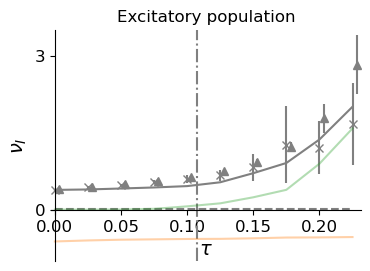

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

idxpop = 0 ### excitatory population 

datasp = firing_rateeq_mean_sp[:,:,idxpop]/Inp[0]
data   = firing_rateeq_mean[:,:,idxpop]/Inp[0]

fig, ax = plt.subplots(figsize=(4,3))
# Plotting
htau = tau_series[1]-tau_series[0]
### error bar with standard deviation of firing_rate_lwfr the axis 0 
std_fr_sp = np.nanstd(datasp,axis=0)
ax.errorbar(tau_series,np.nanmean(datasp.real,axis=0),yerr=std_fr_sp,fmt='x',color='gray',ecolor='gray',alpha=1,ls='',elinewidth=1.5)
std_fr = np.nanstd(data,axis=0)
ax.errorbar(tau_series+htau/8,np.nanmean(data.real,axis=0),yerr=std_fr,fmt='^',color='gray',ecolor='gray',alpha=1,ls='',elinewidth=1.5)
ax.plot(tau_series,np.nanmean(firing_rate_lwfr_sp[:,:,0].real,axis=0)/Inp[0],color='gray',alpha=1,lw=1.5)

### set y-axis    

# ax.set_title('Side-by-Side Boxplots of Data1 and Data2 with Face Color Alpha')

### right and top axes visible = 'false'
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_ylim(-1,3.5)
ax.set_yticks([0,3])

# ax.fill_between(tau_series, trialavg_sparseiid_dyns[0]*np.ones((ntau,))-trialstd_sparseiid_dyns[0]*np.ones((ntau,)),trialavg_sparseiid_dyns[0]*np.ones((ntau,))+trialstd_sparseiid_dyns[0]*np.ones((ntau,)),facecolor='gray',alpha=0.3)


ax.plot(tau_series, trialavg_sparseiid_dyns[0]*np.ones((ntau,)),color='gray',ls='--',alpha=1,lw=1.5)
ax.plot(tau_inter*np.ones(2),[-1,3.5],linestyle='-.',color='gray',linewidth=1.5)

### contribution_fr
### Plot the contributions from individual ranks
htau = tau_series[1]-tau_series[0]
### start with the excitatory neuron population
### contribution from the first rank-1 component Excitatory population
ax.plot(tau_series,np.nanmean(contribution_fr_sp[:,:,0,0].real,axis=0)/Inp[0],color='tab:orange',alpha=0.36,lw=1.5)
ax.plot(tau_series, np.nanmean(contribution_fr_sp[:,:,1,0].real,axis=0)/Inp[0],color='tab:green',alpha=0.36,lw=1.5)

### design the axes
ax.set_xlim(tau_series[0]-htau/8.0,tau_series[-1]+htau/4.0)
ax.set_xticks(tau_series[::2])
### move the axes to the center
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel(r'$\tau$',fontsize=14)
ax.set_ylabel(r'$\nu_{I}$',fontsize=14)
ax.tick_params(labelsize=12)
ax.set_title('Excitatory population',fontsize=12)
plt.show()


Save all variables and parameters

In [ ]:
def list_to_dict(lst, string):
    """
    Transform a list of variables into a dictionary.
    Parameters
    ----------
    lst : list
        list with all variables.
    string : str
        string containing the names, separated by commas.
    Returns
    -------
    d : dict
        dictionary with items in which the keys and the values are specified
        in string and lst values respectively.
    """
    string = string[0]
    string = string.replace(']', '')
    string = string.replace('[', '')
    string = string.replace('\\', '')
    string = string.replace(' ', '')
    string = string.replace('\t', '')
    string = string.replace('\n', '')
    string = string.split(',')
    d = {s: v for s, v in zip(string, lst)}
    return d

In [ ]:
params = {'g':g,
          'gamma':gamma,
          'NE':NE,
          'NI':NI,
          'J':J,
          'ce':ce,
          'ci':ci,
          'tau_series':tau_series,
          }